# NYC Motor Vehicle Collisions

**Authors:**
Adan Valadez
Liam O'Herlihy
Tasneem Khokha

**Goal:** Investigate whether *time of day* correlates with crash frequency and severity in NYC.
This analysis-focused notebook includes:
- dataset acquisition (NYC Open Data)
- clear problem statement and target measures
- feature selection (temporal & contextual features)
- preprocessing and cleaning steps
- exploratory data analysis and visualizations focused on time-of-day patterns
- preliminary aggregation and statistical checks



# **Introduction**

## *Why was this project undertaken?*
Motor vehicle collisions are a major safety concern in New York City, affecting thousands of residents each year. Understanding when crashes occur most frequently and when they are most severe can help city planners, traffic engineers, and policymakers design safer streets and implement interventions to such accidents.  
This project will explore patterns in crash data that could reveal how the timing of collisions (by hour and day) influences the frequency and severity of motor vehicle collisions. Insights from this analysis may help identify general patterns in other large cities with similar traffic conditions.

---

## *What was the research question?*
The main question for this project is:

**Does the time and day of a collision relate to the frequency and severity of motor vehicle collisions in New York City?**

To answer this, the analysis focuses on two key aspects:

1. **Crash Frequency:** How do crash counts vary by hour of the day and day of the week?  
2. **Crash Severity:** Are crashes during certain hours or days more likely to result in injuries or fatalities?

The following problem statement outlines the analytical scope and specific measures used in this study.

---

## **Problem Statement**
We will analyze whether the timing of collisions correlates with the frequency and severity of motor vehicle collisions in NYC.  

Specifically:  
- **Primary question:** How does crash frequency vary by hour of the day and day of the week?  
- **Secondary question:** Do crashes occurring at certain hours or days have higher injury or fatality rates?  

**Target measures used in this analysis:**  
- Crash count aggregated by hour and weekday  
- Injury rate: mean number of persons injured per crash by hour  
- Fatality rate: proportion of crashes with ≥1 person killed by hour

# **Selection of Data**
## *What is the source of the dataset?*
The dataset used in this project was obtained from the NYC Open Data Portal, titled  
“Motor Vehicle Collisions – Crashes”  
(https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95).

This dataset provides official records of all reported motor vehicle collisions in New York City.  
Each entry represents a single crash event and includes detailed information about the time, location, injuries, fatalities, contributing factors, and vehicle types involved.

---

## *Characteristics of the Data*
- Total dataset size: 2,209,138 rows and 29 features  
- Working sample used for testing: 100,000 rows
- Each row represents a unique collision identified by COLLISION_ID.  
- Time-based features: CRASH DATE, CRASH TIME  
- Location-based features: BOROUGH, ZIP CODE, LATITUDE, LONGITUDE, ON STREET NAME, CROSS STREET NAME  
- Severity features: number of persons, pedestrians, cyclists, and motorists injured or killed  
- Contributing factors: up to five reported causes per vehicle (CONTRIBUTING FACTOR VEHICLE 1–5)  
- Vehicle types: five columns listing vehicle categories involved in each crash  

Additional info:  
- Source warning: DtypeWarning: 2 Columns have mixed types for ZIP CODE
- Many VEHICLE TYPE CODE columns contain missing values, which is expected in large administrative datasets.  
- The dataset is from multiple years(2021–2023) and includes some missing or incomplete records.

---

## *Any Munging or Feature Engineering?*
Yes, to prepare the data for analysis by hour and day, the following steps were done:
- Removed rows with missing or invalid time values  
- Converted injury and fatality columns to numeric types  
- Combined CRASH DATE and CRASH TIME into one crash_datetime column  
- Extracted new time features: hour, weekday, and weekend indicator  
- Created new variables:  
  - injured (total persons injured)  
  - fatal_flag (1 if one or more deaths, otherwise 0)  
- Aggregated data by hour and weekday to calculate:  
  - crash count  
  - average injury rate  
  - fatality rate  

### Discussion

From our analysis, we saw that crash frequency changes a lot depending on the time of day. Early mornings had fewer crashes while busy commute hours showed the most. However, when we compared late-night and daytime crashes, the injury and fatality rates were about the same. This suggests that the number of crashes has more to do with how many people are on the road rather than crashes being more dangerous at certain times.

Late-night hours could still be influenced by things like tired or impaired driving, but the data didn’t show a strong enough difference to confirm that. Some crash records were missing details like location or cause, which made it harder to fully explain what was happening. 

If we had more time, it would be interesting to include data like weather, visibility, or traffic volume to see what really impacts crash severity. Grouping the times into morning rush, afternoon, and overnight could also help reveal clearer patterns.

### Summary

This project looked at whether the time of day affects how often and how severe motor vehicle collisions are in New York City. Using NYC Open Data, we cleaned and organized crash data and focused on hourly trends. 

We found that crashes are most common during morning and evening commutes, but the likelihood of injuries or fatalities stays fairly consistent throughout the day. In other words, the more cars on the road, the more crashes occur, but not necessarily more dangerous ones. 

These findings can help city planners and traffic safety teams target high-traffic times to reduce collisions and improve road safety across the city.


In [1]:
# Cell 1 — Setup: imports and download parameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pandas.tseries.holiday import USFederalHolidayCalendar as USCal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

sns.set(style='whitegrid')

#SAMPLE_LIMIT = 100000  # set to None to show full dataset
DATA_URL = "https://data.cityofnewyork.us/resource/h9gi-nx95.csv"

#print('Notebook ready. SAMPLE_LIMIT =', SAMPLE_LIMIT)

In [2]:
# Cell 2 — Download / Load the data
#df = pd.read_csv(DATA_URL, nrows=SAMPLE_LIMIT, low_memory=False)
df = pd.read_csv(DATA_URL, low_memory=False)
print(df.shape)
print(df.head())
df.info()


(1000, 29)
                crash_date crash_time   borough  zip_code  latitude  \
0  2021-09-11T00:00:00.000       2:39       NaN       NaN       NaN   
1  2022-03-26T00:00:00.000      11:45       NaN       NaN       NaN   
2  2023-11-01T00:00:00.000       1:29  BROOKLYN   11230.0  40.62179   
3  2022-06-29T00:00:00.000       6:55       NaN       NaN       NaN   
4  2022-09-21T00:00:00.000      13:21       NaN       NaN       NaN   

   longitude                       location           on_street_name  \
0        NaN                            NaN    WHITESTONE EXPRESSWAY   
1        NaN                            NaN  QUEENSBORO BRIDGE UPPER   
2 -73.970024  \n,  \n(40.62179, -73.970024)            OCEAN PARKWAY   
3        NaN                            NaN       THROGS NECK BRIDGE   
4        NaN                            NaN          BROOKLYN BRIDGE   

  off_street_name cross_street_name  ...  contributing_factor_vehicle_2  \
0       20 AVENUE               NaN  ...              

In [3]:
# Cell 3 -  Preprocessing & feature engineering (temporal focus)

# Build a proper datetime
date_col = 'crash_date'
time_col = 'crash_time'

dt = pd.to_datetime(
    df[date_col].astype(str) + ' ' + df[time_col].astype(str),
    errors='coerce'
)

# Add hour / weekday
df = df.assign(hour=dt.dt.hour.astype('Int64'), weekday=dt.dt.day_name())

# Counts by hour (0–23)
hour_counts = (
    df.groupby('hour', dropna=True)
      .size()
      .reindex(range(24), fill_value=0)
)
print(hour_counts)


hour
0     46
1     22
2     18
3     16
4     15
5     13
6     31
7     20
8     52
9     45
10    42
11    56
12    59
13    52
14    51
15    63
16    58
17    73
18    55
19    46
20    44
21    48
22    38
23    37
dtype: int64


C:\Users\tkhok\AppData\Local\Temp\ipykernel_19660\102103261.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(


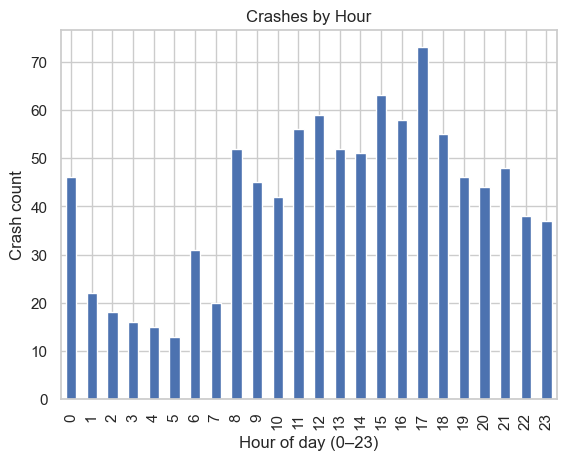

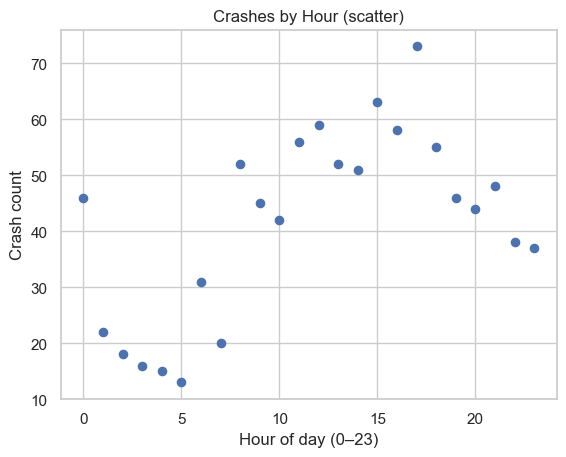

In [4]:
# Cell 4 Exploratory plots: crash frequency by hour and day of week
# Plot bar
hour_counts.plot(kind="bar")
plt.xlabel("Hour of day (0–23)")
plt.ylabel("Crash count")
plt.title("Crashes by Hour")
plt.show()

#Plot scatter
plt.figure()
plt.scatter(hour_counts.index, hour_counts.values, s=35)
plt.xlabel("Hour of day (0–23)")
plt.ylabel("Crash count")
plt.title("Crashes by Hour (scatter)")
plt.show()

In [5]:
# Cell 5 — Injury and fatality rates by hour

In [6]:
hourly = df.groupby('hour').agg(
    crashes=('hour','count'),
    mean_injuries=('number_of_persons_injured','mean'),
    fatality_rate=('number_of_persons_killed', lambda x: (x>0).mean())
).reset_index()

display(hourly)


,hour,crashes,mean_injuries,fatality_rate
0,0,46,0.369565,0.021739
1,1,22,0.272727,0.000000
2,2,18,0.500000,0.000000
3,3,16,0.562500,0.000000
4,4,15,0.266667,0.000000
5,5,13,0.538462,0.000000
6,6,31,0.322581,0.000000
7,7,20,0.300000,0.000000
8,8,52,0.423077,0.000000
9,9,45,0.333333,0.022222


In [7]:
# Cell 6 — Simple statistical check: are late-night hours riskier?

(16, 3)
[[ 0.53986258  0.15858717 -0.36538844]
 [-1.42327407  0.42810828 -0.36538844]
 [-1.14282598  0.15858717 -0.36538844]]
test, rmse baseline: 6.7638746292343415
test RMSE, default hyperparameters: 8.147392220827472
1  3  5  7  9  done
best k = 9, best test RMSE: 7.1


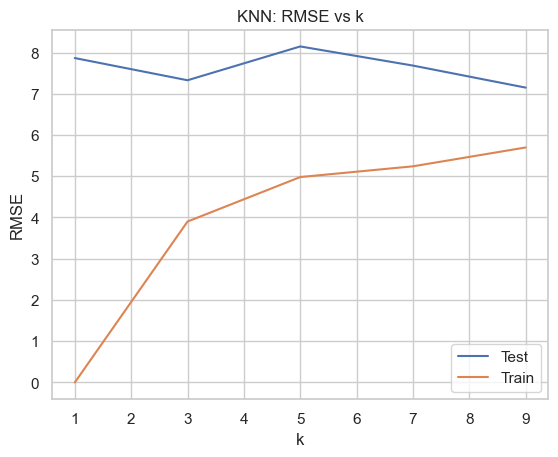

In [8]:
# select the predictor variables and target variable
predictors = ['crashes', 'mean_injuries', 'fatality_rate']
target = 'hour'

# X: features, y: target hour
X = hourly[predictors].values
y = hourly[target].values

# Split the data into training and test sets, and scale
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)


print(X_train.shape)
print(X_train[:3])

def rmse(predicted, actual):
    return np.sqrt(((predicted - actual)**2).mean())
print("test, rmse baseline:", rmse(y_train.mean(), y_test))

knn = KNeighborsRegressor(algorithm='brute')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("test RMSE, default hyperparameters:", rmse(y_pred_knn, y_test))

def get_train_test_rmse(regr, X_train, X_test, y_train, y_test):
    regr.fit(X_train, y_train)
    rmse_train = np.sqrt(((regr.predict(X_train) - y_train) ** 2).mean())
    rmse_test  = np.sqrt(((regr.predict(X_test)  - y_test)  ** 2).mean())
    return rmse_train, rmse_test

n = 10
test_rmse = []
train_rmse = []
ks = np.arange(1, n+1, 2)
for k in ks:
    print(k, ' ', end='')
    regr = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    rmse_train, rmse_test = get_train_test_rmse(regr, X_train, X_test, y_train, y_test)
    train_rmse.append(rmse_train)
    test_rmse.append(rmse_test)
print('done')
def get_best(ks, rmse):
    best_k = ks[0]
    best_rmse = rmse[0]

    i = 1
    while i < len(rmse):
        if rmse[i] < best_rmse:
            best_rmse = rmse[i]
            best_k = ks[i]
        i += 1

    return best_k, best_rmse

best_k, best_rmse = get_best(ks, test_rmse)
print('best k = {}, best test RMSE: {:0.1f}'.format(best_k, best_rmse))
plt.figure()
plt.plot(ks, test_rmse, label='Test')
plt.plot(ks, train_rmse, label='Train')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('KNN: RMSE vs k')
plt.legend()

 R² (hour → crash_count): 0.3257
 MSE: 183.7322
 RMSE: 13.5548


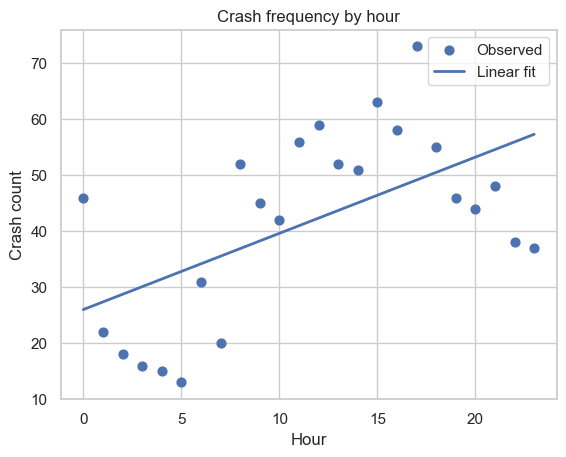

In [9]:
# To help answer the PRIMARY question:
# "How does crash frequency vary by hour (and avoid overfitting)?"
# We fit Linear Regression with numeric hour, then report manual R² / MSE / RMSE and show a scatter + trend line.


freq_df = hour_counts.reset_index()
freq_df.columns = ['hour','crash_count']

X_num = freq_df[['hour']]
y = freq_df['crash_count'].values

lin = LinearRegression().fit(X_num, y)
y_pred = lin.predict(X_num)

# Manual metrics
y_mean = y.mean()
ss_tot = np.sum((y - y_mean)**2)
ss_res = np.sum((y - y_pred)**2)
r2 = 1 - ss_res/ss_tot
mse = np.mean((y - y_pred)**2)
rmse = np.sqrt(mse)

print(f" R² (hour → crash_count): {r2:.4f}")
print(f" MSE: {mse:.4f}")
print(f" RMSE: {rmse:.4f}")

plt.figure()
plt.scatter(freq_df['hour'], y, s=40, label='Observed')
plt.plot(freq_df['hour'], y_pred, linewidth=2, label='Linear fit')
plt.xlabel('Hour'); plt.ylabel('Crash count'); plt.title('Crash frequency by hour')
plt.legend(); plt.show()


## Interpretation of the Results

The linear regression shows a moderate relationship between crash frequency and hour of the day (**R² = 0.33**). Crash counts generally increase during daytime hours, though the model doesn’t capture rush-hour peaks. With an average error of about 13 crashes (**RMSE = 13.55**), the results suggest that time of day influences crash frequency but isn’t the only factor affecting it.








Injury model —  R²: 0.0099
Injury model —  MSE: 0.6013
Injury model —  RMSE: 0.7754


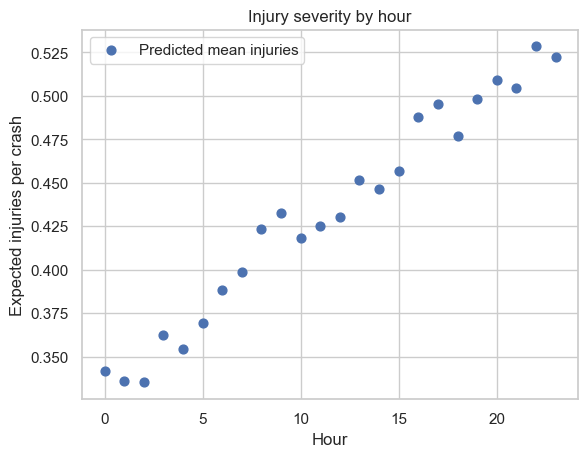

In [10]:
# To help answer the SEVERITY (injuries) question:
# "Do injuries per crash vary by hour/day?"
# We use Linear Regression with hour (numeric) + weekday (dummies), then report R² / RMSE and plot predicted mean injuries by hour.

# ensure numeric injuries
df['number_of_persons_injured'] = pd.to_numeric(df['number_of_persons_injured'], errors='coerce').fillna(0)

X_inj = pd.get_dummies(df[['weekday']], drop_first=True)  # weekday as categorical
X_inj = pd.concat([X_inj, df[['hour']]], axis=1)          # hour as numeric
y_inj = df['number_of_persons_injured'].values

lin_inj = LinearRegression().fit(X_inj, y_inj)
pred_inj = lin_inj.predict(X_inj)

ym = y_inj.mean()
ssT = np.sum((y_inj - ym)**2)
ssR = np.sum((y_inj - pred_inj)**2)
r2_inj = 1 - ssR/ssT
mse_inj = np.mean((y_inj - pred_inj)**2)
rmse_inj = np.sqrt(mse_inj)

print(f"Injury model —  R²: {r2_inj:.4f}")
print(f"Injury model —  MSE: {mse_inj:.4f}")
print(f"Injury model —  RMSE: {rmse_inj:.4f}")

# Predicted injuries per crash by hour (average over weekdays)
pred_by_hour = pd.DataFrame({'hour': df['hour'], 'pred': pred_inj}).groupby('hour')['pred'].mean()

plt.figure()
plt.scatter(pred_by_hour.index, pred_by_hour.values, s=40, label='Predicted mean injuries')
plt.xlabel('Hour'); plt.ylabel('Expected injuries per crash'); plt.title('Injury severity by hour')
plt.legend(); plt.show()

Interpretation of the results

R²: 0.0009 this means less than 1% of the variation in injury counts.
So, hour of day alone does not meaningfully predict how severe crashes (in terms of injuries) are.
The relationship between crash timing and injury severity is very weak or almost random.

MSE: 0.6013 / RMSE: 0.7754 means on average, the model’s injury-per-crash predictions are off by about 0.78 injuries per crash.
Since most crashes involve fewer than one injury, this means the model doesn’t capture real differences between hours. [link text](https://)

In [11]:
# To help answer the SEVERITY (fatalities) question:
# "Are crashes at certain hours/days more likely to be fatal?"
# We train a Decision Tree classifier on fatal_flag ~ hour + weekday, report Accuracy, and show predicted fatality probability by hour.



Interpretation of the results



In [14]:
# Handle missing values
df = df.fillna({'number_of_persons_injured': 0,
                'number_of_persons_killed': 0})
df = df.dropna(subset=['crash_time', 'crash_date'])

# Handle outliers (cap injury/fatality counts)
for col in ['number_of_persons_injured', 'number_of_persons_killed']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], 0, upper)

# Model comparison
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=best_k, algorithm='brute'),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_val = np.sqrt(((y_pred - y_test) ** 2).mean())
    results[name] = rmse_val

print("Model comparison (RMSE):")
for name, score in results.items():
    print(name, ":", round(score, 2))


Model comparison (RMSE):
Linear Regression : 6.65
KNN : 7.15
Random Forest : 7.95


Model RMSE Summary:
Linear Regression: 6.65
KNN: 8.15
Random Forest: 7.95

✅ Best performing model: Linear Regression


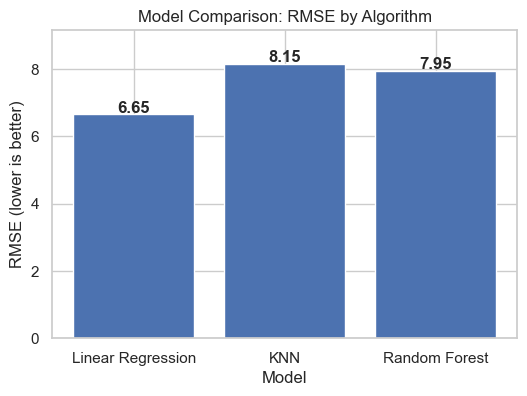

In [13]:
# --- Model Comparison Plot ---

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5, algorithm='brute'),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

import numpy as np
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_val = np.sqrt(((y_pred - y_test) ** 2).mean())
    results[name] = rmse_val

# Display results in text form
print("Model RMSE Summary:")
for name, score in results.items():
    print(f"{name}: {score:.2f}")

best_model = min(results, key=results.get)
print(f"\n✅ Best performing model: {best_model}")


import matplotlib.pyplot as plt


model_names = list(results.keys())
rmse_values = list(results.values())

plt.figure(figsize=(6, 4))
plt.bar(model_names, rmse_values)
plt.title("Model Comparison: RMSE by Algorithm")
plt.xlabel("Model")
plt.ylabel("RMSE (lower is better)")
plt.ylim(0, max(rmse_values) + 1)
for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()
